# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from phik.report import plot_correlation_matrix
from phik import report

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    LabelEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    PolynomialFeatures
)
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LinearRegression

## Подготовка данных

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [3]:
def primary_information(df):
    print(f"Размерность: {df.shape}")
    display(df.info())
    display(df.head())

In [4]:
primary_information(df)

Размерность: (354369, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Приведем даты к типу `datetime`

In [5]:
df['DateCrawled'] = pd.to_datetime(
    df['DateCrawled'], format="%Y-%m-%d"
)
df['DateCreated'] = pd.to_datetime(
    df['DateCreated'], format="%Y-%m-%d"
)
df['LastSeen'] = pd.to_datetime(
    df['LastSeen'], format="%Y-%m-%d"
)

In [6]:
num_cols = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode']
cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'   ]

In [7]:
def draw_boxplots(df, cols, title):
    fig, axs = plt.subplots(ncols=len(cols), nrows=1, figsize=(16, 4))
    for i in range(len(cols)):
        sns.boxplot(data = df, y=cols[i], ax=axs[i])
        axs[i].set_xlabel(cols[i])
        axs[i].set_ylabel('')
    fig.suptitle(title, fontsize=30);

In [8]:
len(df['PostalCode'].unique())

8143

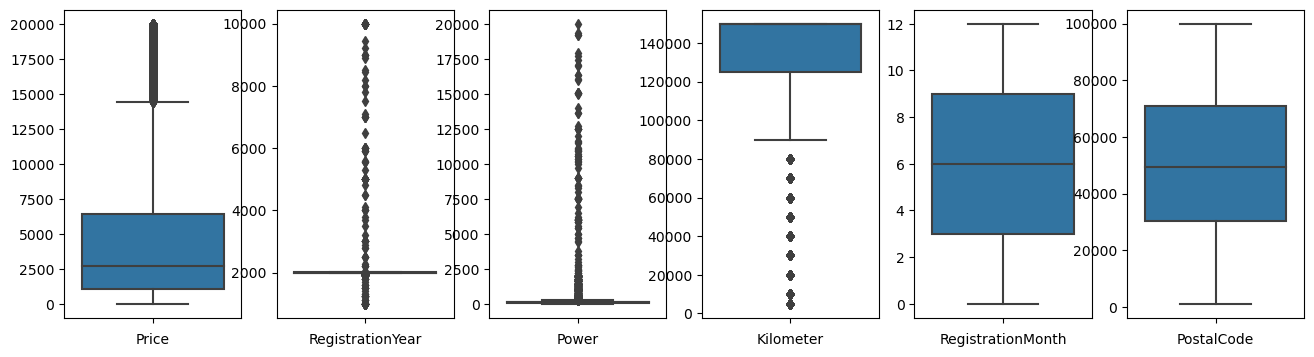

In [9]:
draw_boxplots(df, num_cols, "")

Поле `RegistrationYear` явно имеет аномальные значения. Избавимся от строк с аномальными значениями

In [10]:
df.drop(df[df['RegistrationYear'] > 2024].index, inplace = True)
df.drop(df[df['RegistrationYear'] < 1920].index, inplace = True)

In [11]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37246
RegistrationYear         0
Gearbox              19619
Power                    0
Model                19566
Kilometer                0
RegistrationMonth        0
FuelType             32691
Brand                    0
Repaired             70919
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [12]:
df['VehicleType'] = df['VehicleType'].fillna('not_indicated')
df['Gearbox'] = df['Gearbox'].fillna('not_indicated')
df['FuelType'] = df['FuelType'].fillna('not_indicated')
df['Model'] = df['Model'].fillna('not_indicated')
df['Repaired'] = df['Repaired'].fillna('not_indicated')

Оценим какие признаки не могут влиять на стоимость автомобиля, примем их неинформативными и удалим:
- DateCrawled — дата скачивания анкеты из базы
- RegistrationMonth — месяц регистрации автомобиля
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

In [13]:
def draw_scatterplot_with_product(df, cols):
    fig, axs = plt.subplots(ncols=len(cols), nrows=1, figsize=(16, 4))
    for i in range(len(cols)):
        sns.scatterplot(data=df, x='Price', y=cols[i], ax=axs[i])
    fig.suptitle(f"Диаграммы рассеяния для стоимости авто и {cols[i]}", fontsize=20)

In [14]:
def show_pie(df, columns, main_title):
    fig, axes = plt.subplots(nrows=1, ncols=len(columns), sharey=True, figsize=(18, 6))
    if len(columns) == 1:
        (
            df[columns[0]].value_counts().plot.pie(autopct='%1.f%%', legend=False,
                wedgeprops = {"edgecolor" : "white", 
                              'linewidth': 2, 
                              'antialiased': True})
        )
        axes.title.set_text(columns[0])
    else:
        idx = 0
        for column in columns:    
            (
                df[column].value_counts().plot.pie(ax=axes[idx], autopct='%1.f%%', legend=False,
                    wedgeprops = {"edgecolor" : "white", 
                                  'linewidth': 2, 
                                  'antialiased': True})
            )
            axes[idx].title.set_text(columns[idx])
            idx+=1
    fig.suptitle(main_title, fontsize=30)

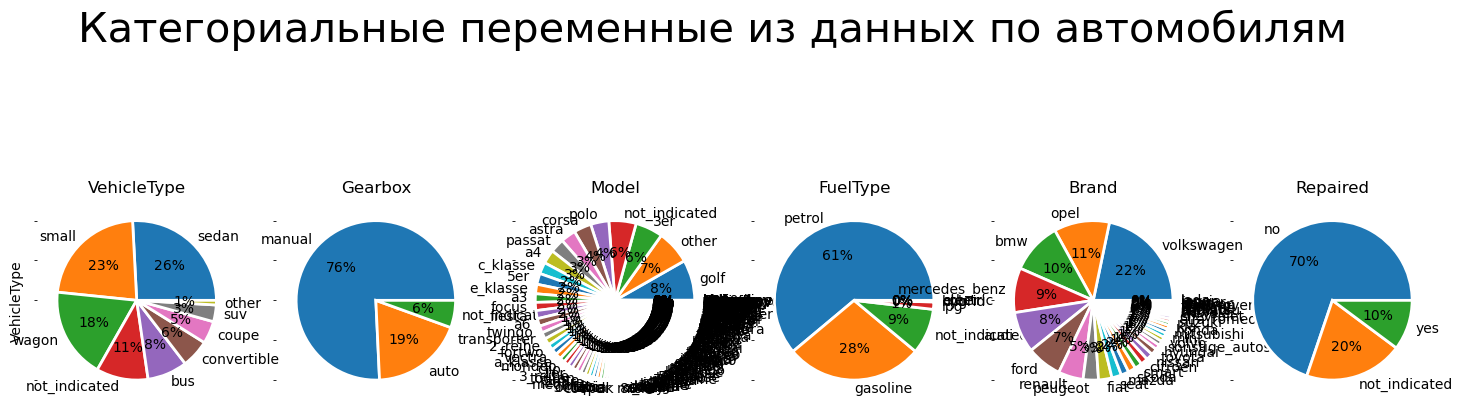

In [15]:
show_pie(
    df, 
    cat_cols,
    'Категориальные переменные из данных по автомобилям'
)

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode']


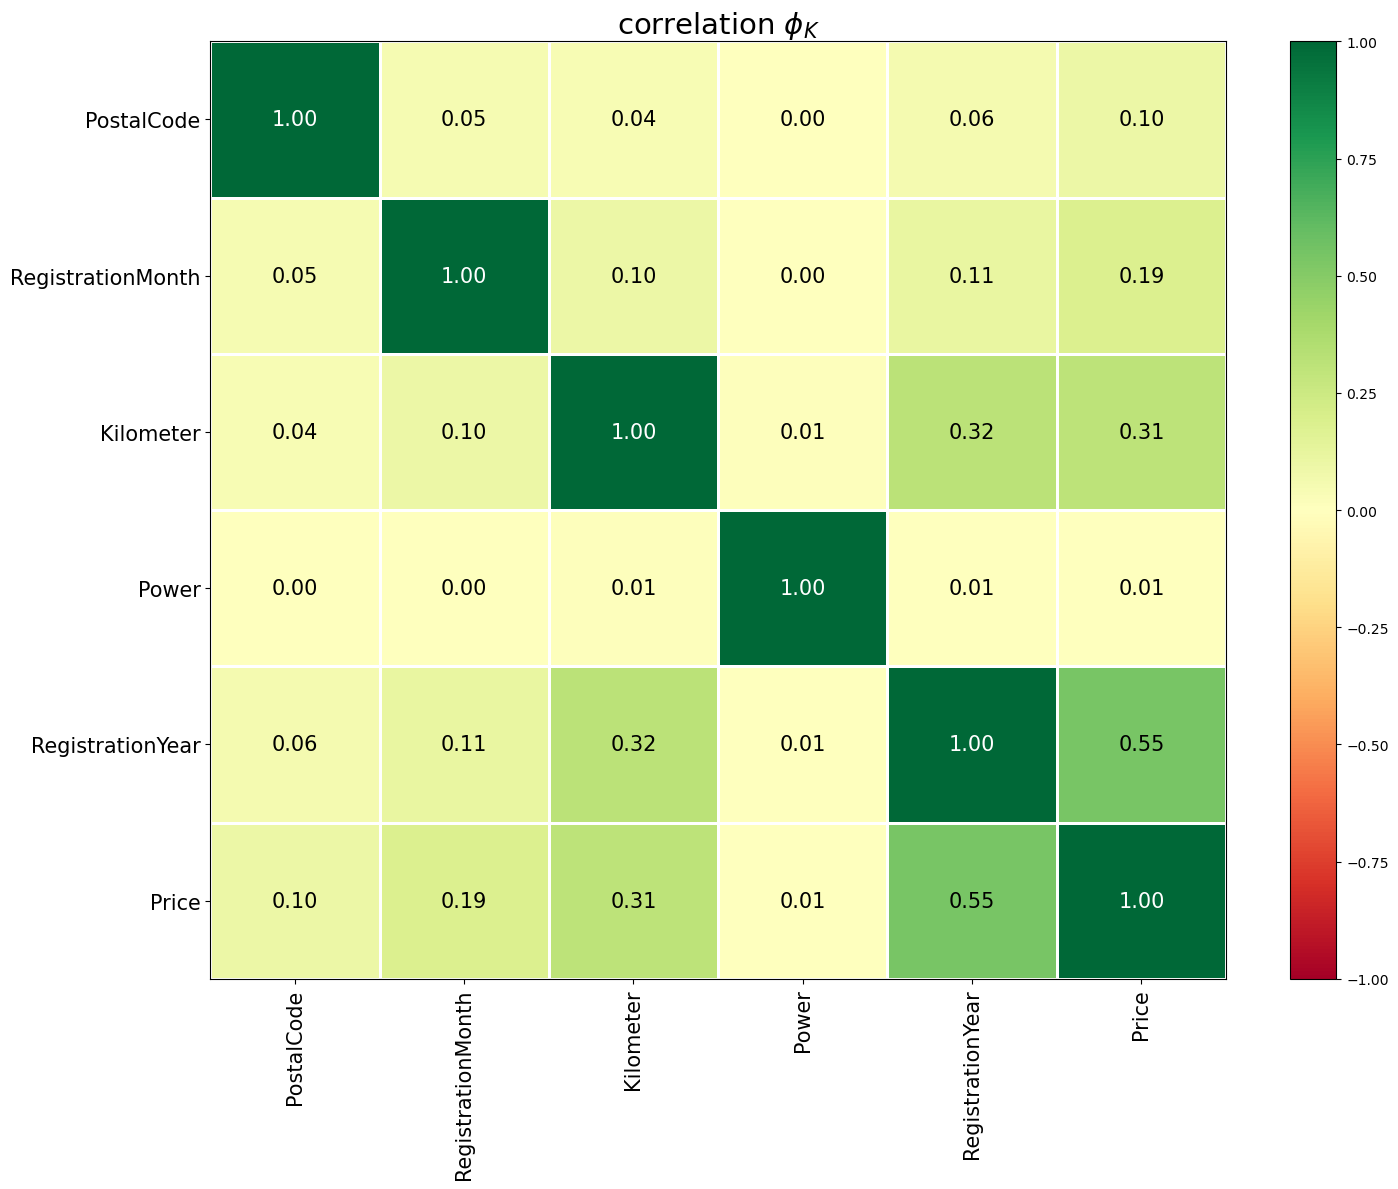

In [16]:
phik_overview = df[num_cols].phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

In [27]:
df = df.drop(['NumberOfPictures', 'DateCrawled', 'DateCreated', 'LastSeen'], axis=1)

## Обучение моделей

In [28]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [29]:
ohe_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
num_columns = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

In [44]:
def fit_predict(df):
    X = df.drop(['Price'], axis=1)
    y = df['Price']
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y,
        test_size=0.25,
        random_state=RANDOM_STATE
    )
    ohe_pipe = Pipeline(
        [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
         ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
        ]
    )
    data_preprocessor = ColumnTransformer(
        [
            ('ohe', ohe_pipe, ohe_columns),
            ('num', StandardScaler(), num_columns),
        ], 
        remainder='passthrough'
    )
    X_train_preprocessed = data_preprocessor.fit_transform(X_train)
    X_test_preprocessed = data_preprocessor.transform(X_test)

    poly_model = Pipeline([('poly', PolynomialFeatures()),
                      ('linear', LinearRegression(fit_intercept=False))])
    param_grid = {
        'poly__degree': range(1, 5)
    }
    grid_search = GridSearchCV(
        poly_model, 
        param_grid, 
        cv=5,
        n_jobs=-1
    )
    grid_search.fit(X_train_preprocessed, y_train)
    best_poly_model = grid_search.best_estimator_
    print (f"Метрика SMAPE модели LinearRegression на кросс-валидации: {-grid_search.best_score_:.2f}")

In [ ]:
fit_predict(df)

## Анализ моделей

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей